# Introducción
En este notebook se demuestra lo esencial del análisis de series temporales. Los conjuntos de datos utilizados son los datos macroeconómicos de EE.UU. y los datos de pasajeros de líneas aéreas.

- Filtro de Hodrick Prescott para separar los componentes de tendencia y cíclicos
- Descomposición de errores, tendencias y estacionalidad mediante Statsmodels Descomposición estacional
- Alisamiento exponencial utilizando Pandas EWMA y el método de Holt Winters para el alisamiento exponencial simple, doble y triple.
- Previsión del futuro real mediante el método exponencial triple de Holt Winters

In [1]:
# arrays and dataframes
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# time series - statsmodels
from statsmodels.tsa.filters.hp_filter import hpfilter  # Hodrick Prescott filter for cyclic & trend separation
from statsmodels.tsa.seasonal import seasonal_decompose # Error Trend Seasonality decomposition

# holt winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

# Part I - Time Series Decomposition
## Import Libraries
Note the statsmodels specific libraries used in this kernel.

## Hodrick Prescott Filter
El filtro de Hodrick Prescott se utiliza para separar la tendencia y el componente cíclico de los datos de la serie temporal. Los componentes se determinan minimizando la función de pérdida cuadrática, en la que un elemento importante es lambda, que es el parámetro de suavizado. El valor recomendado de lambda es 1600 cuando se analizan datos trimestrales, 6,25 para datos anuales y 129.600 para datos mensuales. Al eliminar el componente cíclico, los datos son más sensibles a las fluctuaciones a largo plazo que a las fluctuaciones a corto plazo. Esto es especialmente importante para analizar el PIB.

Lea más sobre el filtro de Hodrick Prescott aquí: https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter

Vamos a usar este conjunto de datos pero acá hay muchos más: https://www.kaggle.com/datasets/prakharprasad/time-series-data-1/. Además por su puesto usted pudera usar su propio conjunto de datos...

In [2]:
# US Macro economic data
usmacro = pd.read_csv('../datas/macrodata.csv',index_col=0,parse_dates=True)

In [3]:
usmacro

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-30,2008,3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-12-31,2008,4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-03-31,2009,1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009-06-30,2009,2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


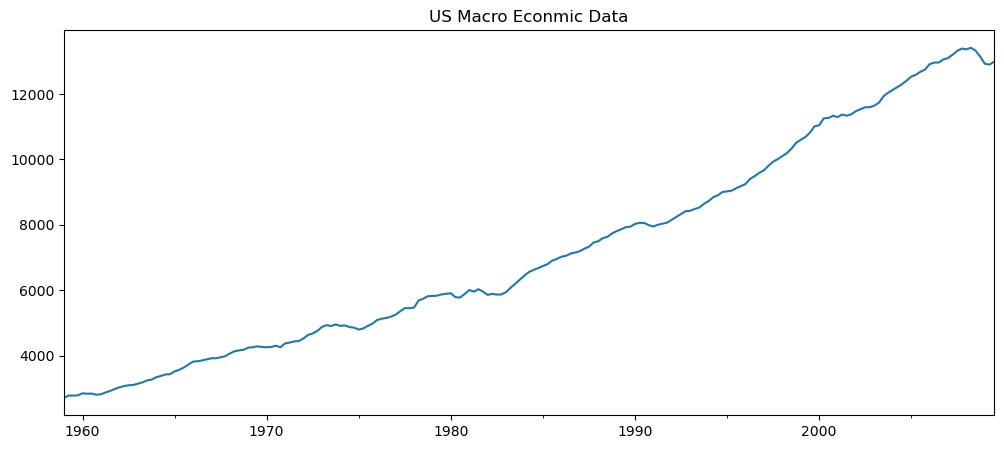

In [4]:
# visualize the realgdp --- > will use the capabilities of pandas plotting capability
usmacro['realgdp'].plot(figsize=(12,5),title='US Macro Econmic Data').autoscale(axis='x',tight=True)

The trend and cycles can be separated using tuple unpacking

In [5]:
# tuple unpacking, lambda as 1600 to analyze the quarterly trend 
cycles,trend = hpfilter(usmacro['realgdp'],lamb=1600) 

Vamos a añadir la tendencia como una columna adicional en el marco de datos - hace más fácil el trazado con pandas

In [6]:
usmacro['gdp_trend'] = trend
usmacro['gdp_cycles'] = cycles

In [7]:
usmacro

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,gdp_trend,gdp_cycles
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,2670.837085,39.511915
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,2698.712468,80.088532
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,2726.612545,48.875455
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,2754.612067,30.591933
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,2782.816333,64.882667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-30,2008,3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,13222.581545,102.018455
2008-12-31,2008,4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,13249.189472,-107.269472
2009-03-31,2009,1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,13274.457706,-349.047706
2009-06-30,2009,2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19,13299.061073,-397.557073


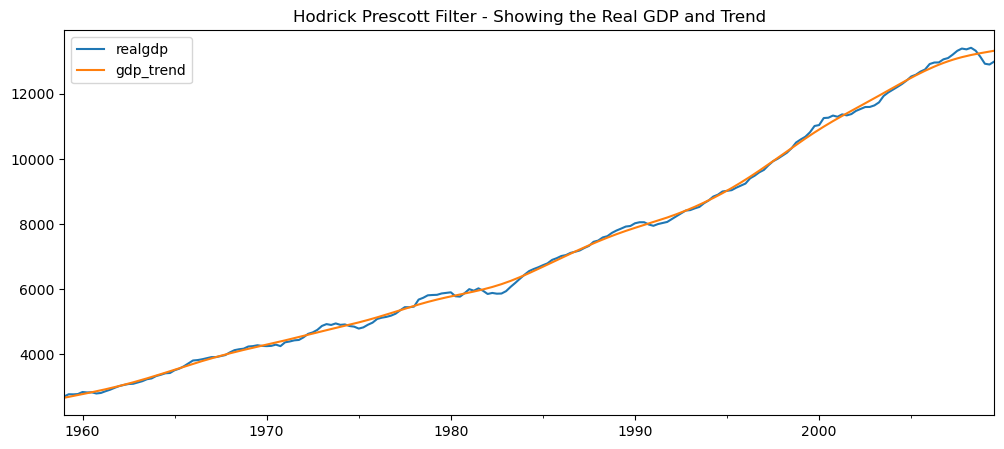

In [8]:
# Plot the trend component
usmacro[['realgdp','gdp_trend']].plot(figsize=(12,5),title='Hodrick Prescott Filter - Showing the Real GDP and Trend').autoscale(axis='x',tight=True)

Ahora tenemos la tendencia del PIB, que es sensible a las fluctuaciones a largo plazo y no a las fluctuaciones a corto plazo. Esto tiene más sentido para analizar el ciclo de vida de la empresa a lo largo de un periodo bien definido. Del mismo modo, la tendencia puede analizarse variando los valores de lambda para comprobar la tendencia anual y mensual.

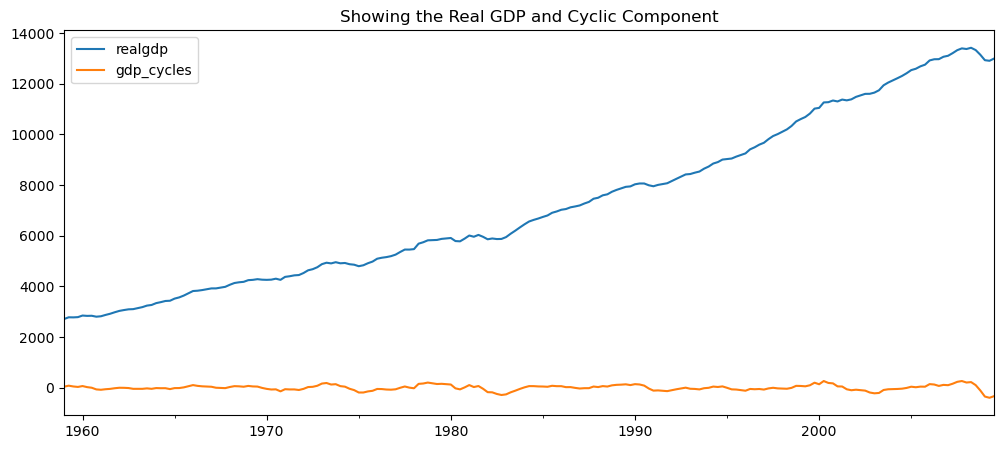

In [9]:
# Plot the cyclic component
usmacro[['realgdp','gdp_cycles']].plot(figsize=(12,5),title='Showing the Real GDP and Cyclic Component').autoscale(axis='x',tight=True)

Veamos esto desde el año 2000

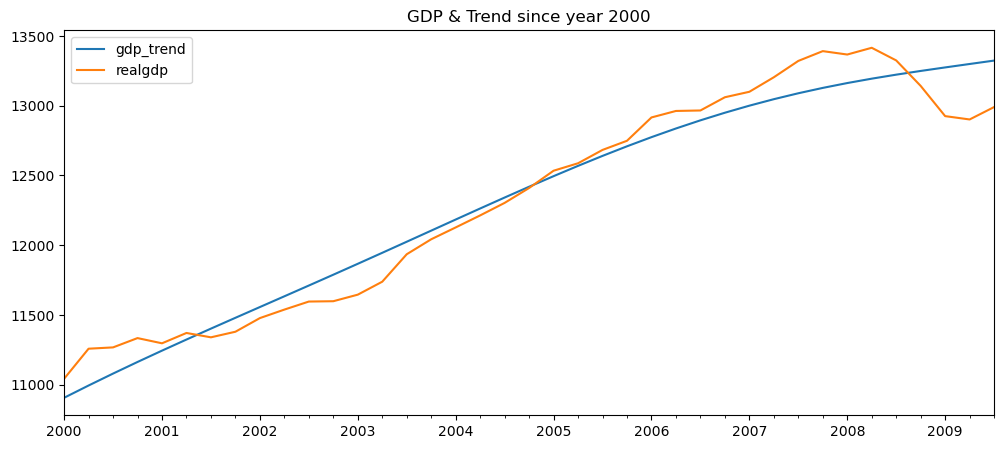

In [10]:
usmacro[['gdp_trend','realgdp']]['2000-03-31':].plot(figsize=(12,5),title='GDP & Trend since year 2000').autoscale(axis='x',tight=True);

# ETS - Descomposición de errores, tendencias y estacionalidad
La descomposición de una serie temporal intenta aislar componentes individuales como el error, la tendencia y la estacionalidad. Statsmodels proporciona una herramienta de descomposición estacional para separar los distintos componentes.

Para demostrar la capacidad de descomposición estacional de statsmodels, utilizaré los datos de pasajeros de líneas aéreas.

Recuerde: el modelo aditivo se utiliza cuando el componente de tendencia es más constante a lo largo del tiempo. Por ejemplo, cada año se añaden 20.000 pasajeros. El modelo multiplicativo se utiliza cuando la tendencia aumenta/disminuye a un ritmo no lineal. ejemplo, cada año el número de pasajeros de líneas aéreas se duplica en 20.000.

In [11]:
airline = pd.read_csv('../datas/airline_passengers.csv',index_col='Month', parse_dates=True)

In [12]:
airline

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [13]:
# decompose the time series
decompose_result = seasonal_decompose(airline['Thousands of Passengers'],model='multiplicative')

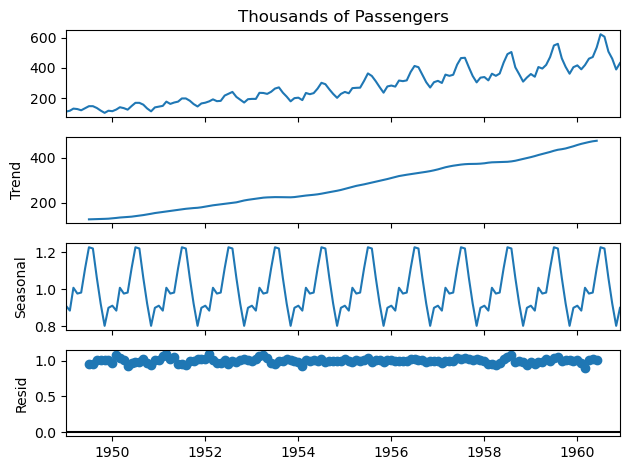

In [14]:
decompose_result.plot()
plt.show()

# Part II - Fit various smoothing models to existing data
## Moving Averages
### SMA - Simple Moving Averages

In [15]:
airline.dropna(inplace=True)

In [16]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()

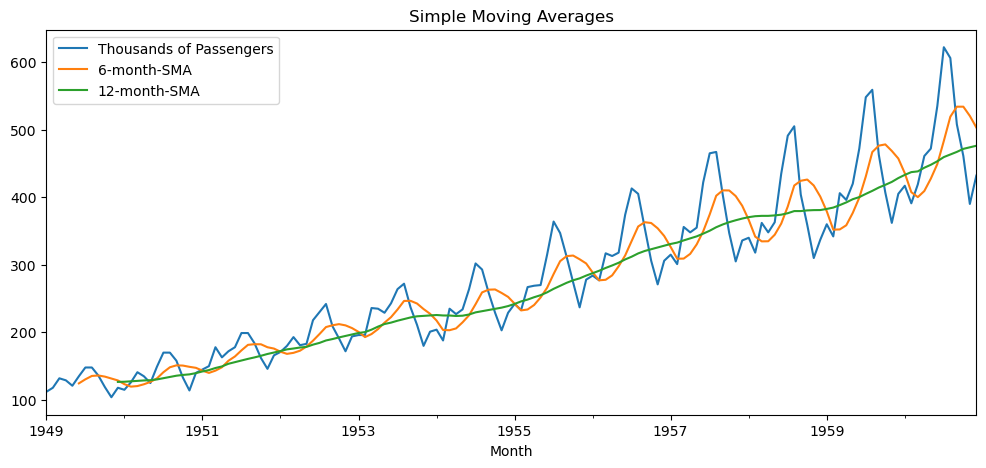

In [17]:
airline.plot(figsize=(12,5),title='Simple Moving Averages')
plt.show()

In [18]:
airline.head(12) 

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


Tenga en cuenta que el rolling introduce el NaN en función del tamaño de ventana seleccionado. Sin embargo, existen algunas desventajas de la media móvil simple

Las ventanas más pequeñas producirán más ruido que señal.
Siempre se retrasará por el tamaño de la ventana (ver la MA comienza después de un cierto retraso por encima de la figura)
Nunca alcanzará el pico o valle completo de los datos debido a la promediación.
No le informa realmente sobre posibles comportamientos futuros, todo lo que hace es describir tendencias en sus datos.
Los valores históricos extremos pueden sesgar significativamente su SMA
Para ayudar a solucionar algunos de estos problemas, tenemos la EWMA o la Media Móvil Ponderada Exponencialmente

### EWMA - Media móvil ponderada exponencialmente
EWMA permite reducir el desfase dando más peso a las lecturas o valores recientes. La cantidad de peso aplicado depende de los parámetros reales en la EWMA y el número de períodos dados en un tamaño de ventana. Encontrará más información en https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows

Tenga en cuenta que el EWMA aplica un alisamiento exponencial único.

In [19]:
airline['ewma12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()
airline['ewma24'] = airline['Thousands of Passengers'].ewm(span=24,adjust=False).mean()

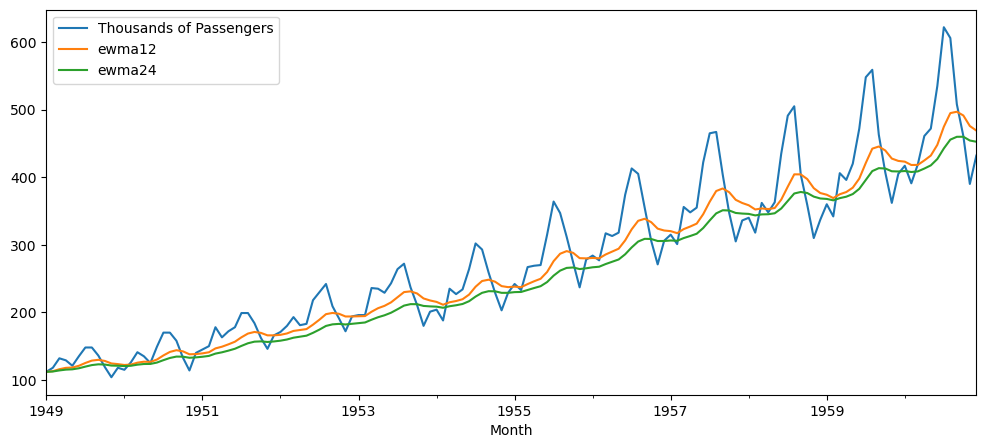

In [20]:
airline[['Thousands of Passengers','ewma12','ewma24']].plot(figsize=(12,5))
plt.show()

Comparando SMA to EWMA

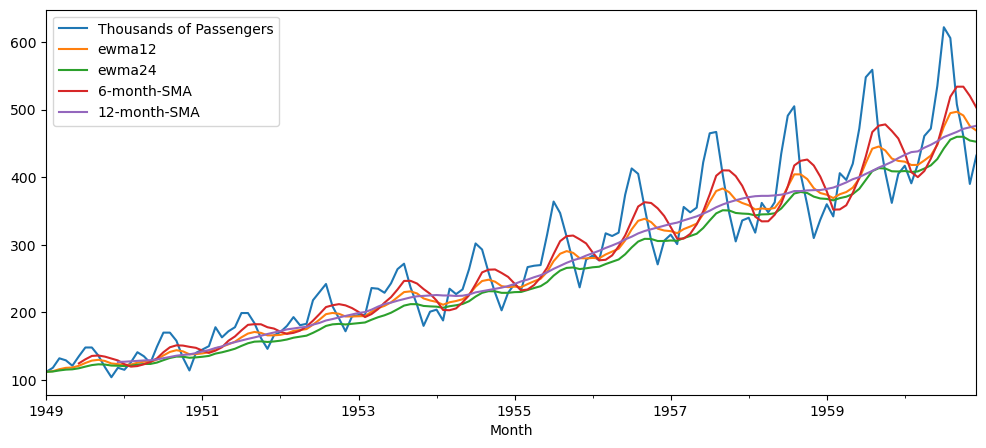

In [21]:
airline[['Thousands of Passengers','ewma12','ewma24','6-month-SMA','12-month-SMA']].plot(figsize=(12,5))
plt.show()

## Holt Winters - Suavizado exponencial simple, doble y triple
Los promedios móviles y el alisamiento exponencial simple no son buenos pronósticos cuando hay tendencia y estacionalidad en los datos. El alisamiento exponencial doble y triple es el más adecuado para este tipo de datos de series temporales. Holt Winters tiene las tres variantes: alisamiento exponencial simple, doble y triple.

El alisamiento exponencial doble utiliza un factor de alisamiento que tiene en cuenta la tendencia. El suavizado exponencial triple utiliza un factor de suavizado que tiene en cuenta la estacionalidad.

Span corresponde a lo que comúnmente se denomina "media móvil EW de N días".Alpha especifica directamente el factor de suavizado. Mire aqui: https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows

In [22]:
# set the span and the smoothing factor alpha
span = 12
alpha = 2/(span+1)
airline.columns
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Para trabajar con modelos de previsión como Holt Winters, ARIMA, SARIMA, etc., es necesario establecer la frecuencia del índice de fechas. El índice del conjunto de datos de pasajeros de líneas aéreas indica las fechas de principio de mes. Por lo tanto, podemos establecerlo como "MS".

In [23]:
# Set the frequency of the date time index as Monthly start as indicated by the data
airline.index.freq = 'MS' 

## Suavizado exponencial simple - Usando Holt Winters
Esto es lo mismo que el método ewm en Pandas

In [24]:
airline['SES12'] = SimpleExpSmoothing(airline['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

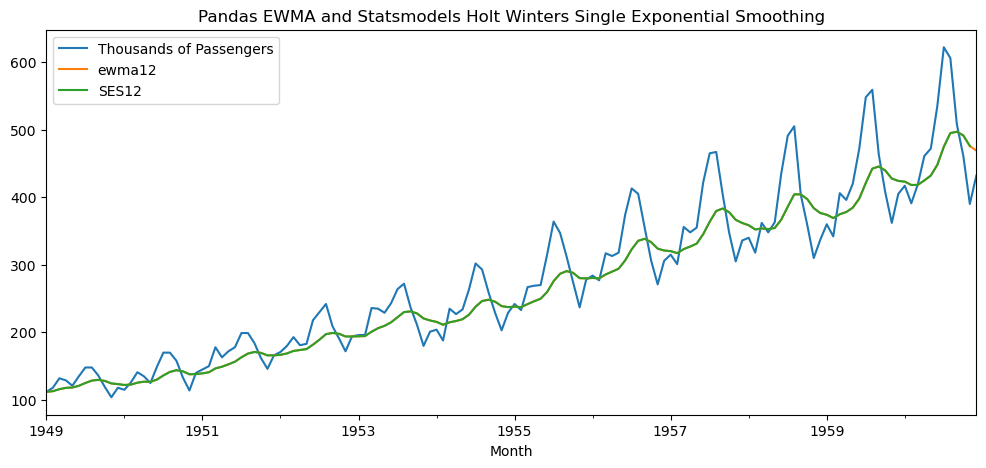

In [25]:
airline[['Thousands of Passengers','ewma12','SES12']].plot(figsize=(12,5),title='Pandas EWMA and Statsmodels Holt Winters Single Exponential Smoothing')
plt.show()

Tanto la curva EWMA como la curva de suavizado exponencial simple de Holt Winters se ajustan completamente entre sí.

## Double Exponential Smoothing

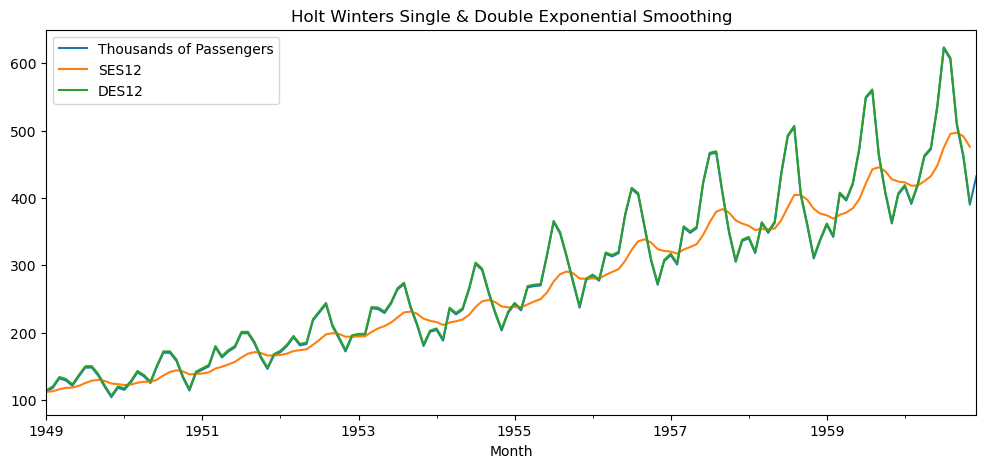

In [26]:
airline['DES12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='add').fit().fittedvalues.shift(-1)
airline[['Thousands of Passengers','SES12','DES12']].plot(figsize=(12,5),title='Holt Winters Single & Double Exponential Smoothing');

Aquí, el alisado exponencial doble se solapa completamente con los datos originales. Vamos a trazar para los últimos 24 meses.

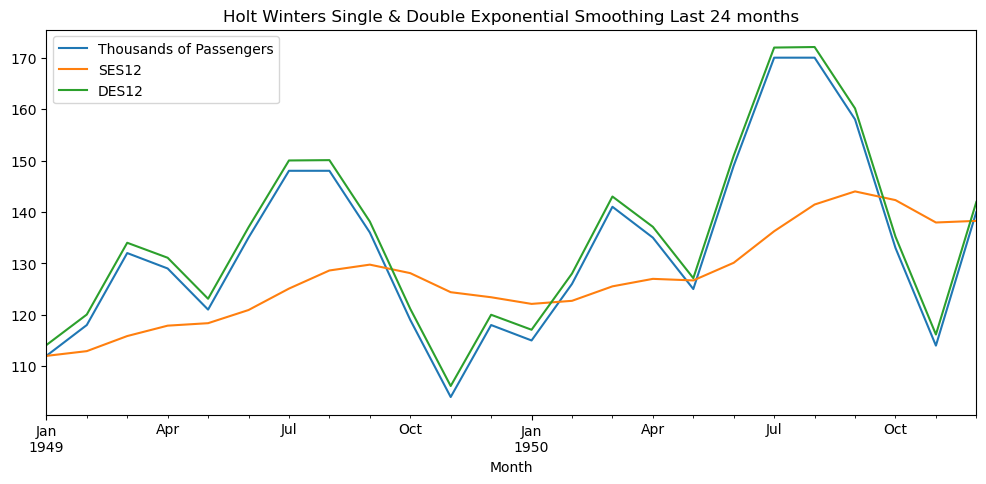

In [27]:
airline[['Thousands of Passengers','SES12','DES12']].iloc[:24].plot(figsize=(12,5),title='Holt Winters Single & Double Exponential Smoothing Last 24 months').autoscale(axis='x',tight=True);

Replanteemos lo anterior utilizando el ajuste multiplicativo en lugar del aditivo.

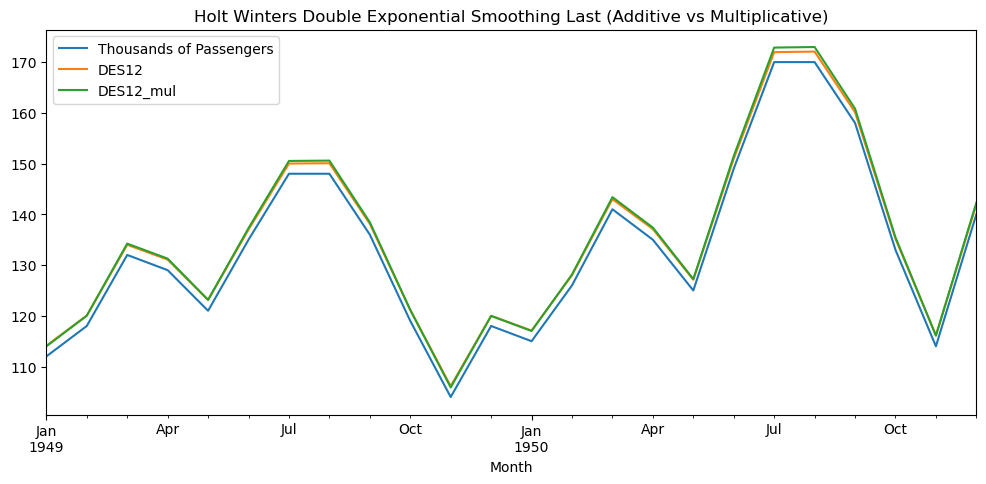

In [28]:
airline['DES12_mul'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul').fit().fittedvalues.shift(-1)
airline[['Thousands of Passengers','DES12','DES12_mul']].iloc[:24].plot(figsize=(12,5),title='Holt Winters Double Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True)
plt.show()

Aunque de menor importancia, el ajuste multiplicativo da un mejor resultado en comparación con el ajuste aditivo de la tendencia.

## Triple Exponential Smoothing

In [29]:
airline['TESadd12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

/home/dsp/.local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


[]

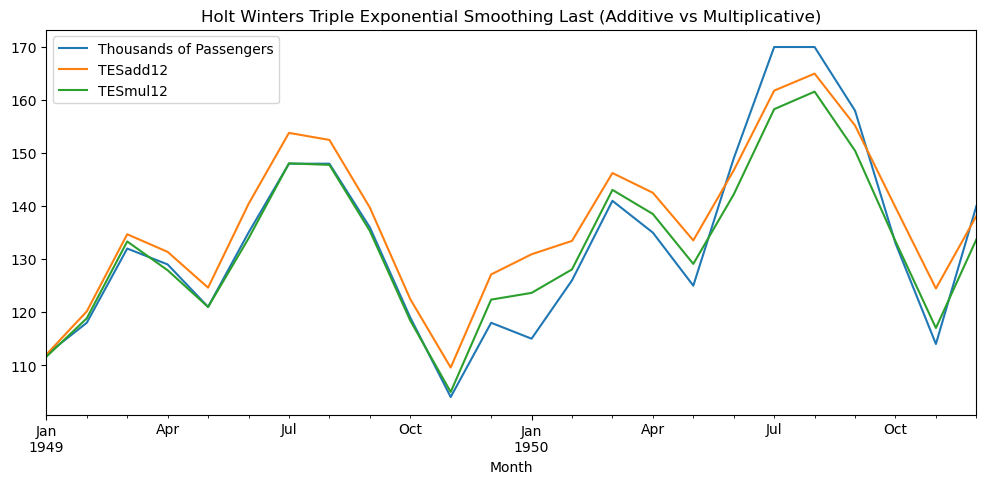

In [30]:
airline['TESmul12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
airline[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,5),title='Holt Winters Triple Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True)
plt.plot()

# Parte III - Forecasting con el método de Holt Winters
Volvamos a leer los datos de la aerolínea para tener una copia fresca

In [31]:
airline  = pd.read_csv('../datas/airline_passengers.csv',index_col='Month',parse_dates=True)
airline.index.freq = 'MS'

Separe en un par de conjuntos de entrenamiento y prueba

In [32]:
# Split into train and test set
train_airline = airline[:108] 
test_airline = airline[108:] 
len(test_airline)

36

Fit the model on the train set
Seasonal periods with value 12 indicates the seasonality we expect in the data. for airline passenger we can safely assume that the seasonality would repeat every 12 months.

In [33]:
fitted_model = ExponentialSmoothing(train_airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(36).rename('HW Test Forecast')

/home/dsp/.local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


[]

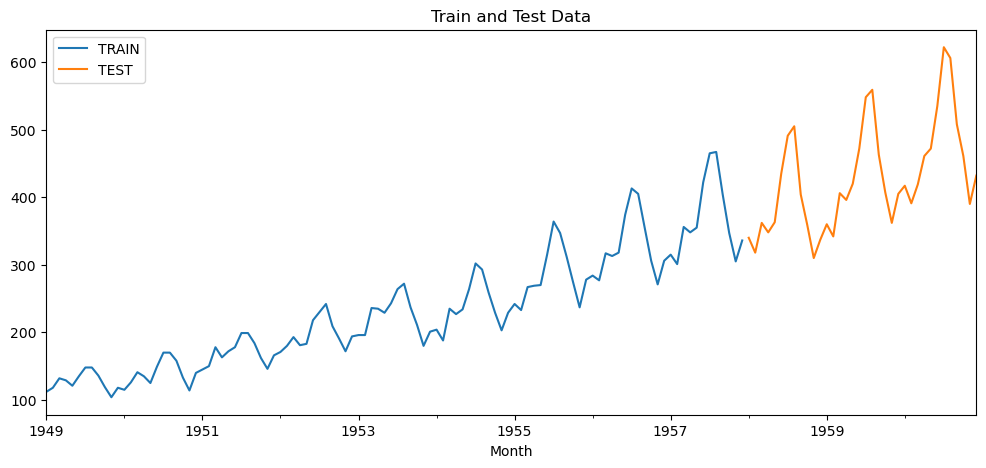

In [34]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,5))
plt.title('Train and Test Data')
plt.plot()

Ahora plotee también las predicciones...

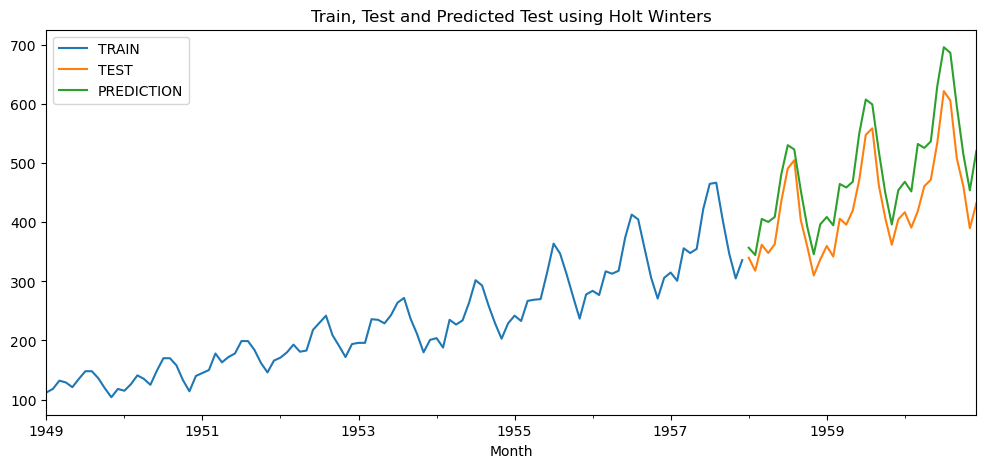

In [35]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

Ploteemos los eventos más recientes...

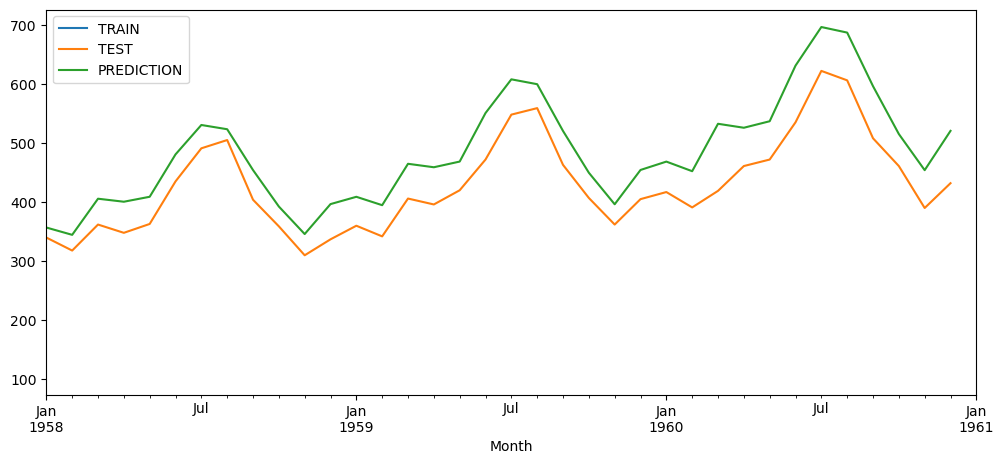

In [36]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01'])
plt.show()

### Evaluation metrics

In [37]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print(f'Mean Absolute Error = {mean_absolute_error(test_airline,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_airline,test_predictions)}')
print(f'Root Mean Squared Error = {np.sqrt(mean_squared_error(test_airline,test_predictions))}')
test_airline.describe()

Mean Absolute Error = 55.69782636118518
Mean Squared Error = 3525.867525316523
Root Mean Squared Error = 59.37901586685757


,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


The predictions are not as bad as I thought earlier. The MAE is very less compared to the mean of the true test data. So not a bad job till now.

## Forecast into the future
Till now, we predicted the test values and compared with the true test values. The true forecast can only be once it is done for the real future !!

/home/dsp/.local/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


[]

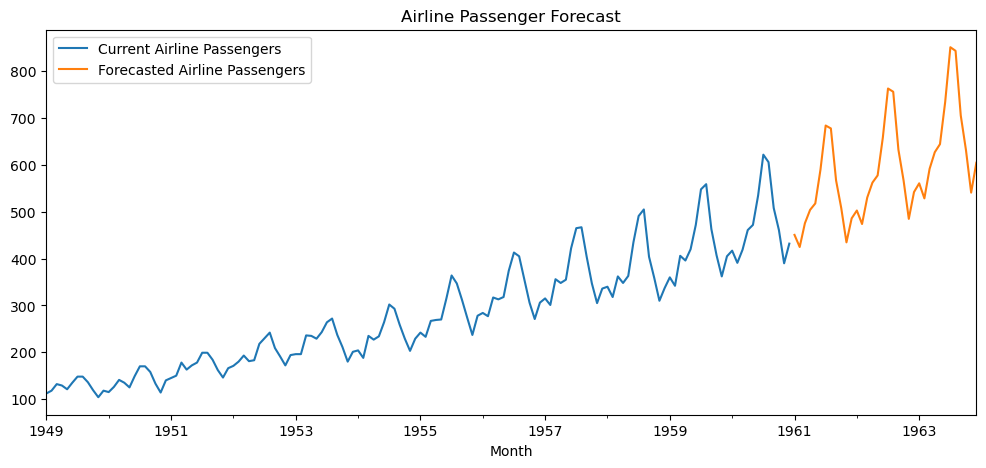

In [38]:
final_model = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
forecast_predictions = final_model.forecast(steps=36)
airline['Thousands of Passengers'].plot(figsize=(12,5),legend=True,label='Current Airline Passengers')
forecast_predictions.plot(legend=True,label='Forecasted Airline Passengers')
plt.title('Airline Passenger Forecast')
plt.plot()

In [39]:
airline

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


[]

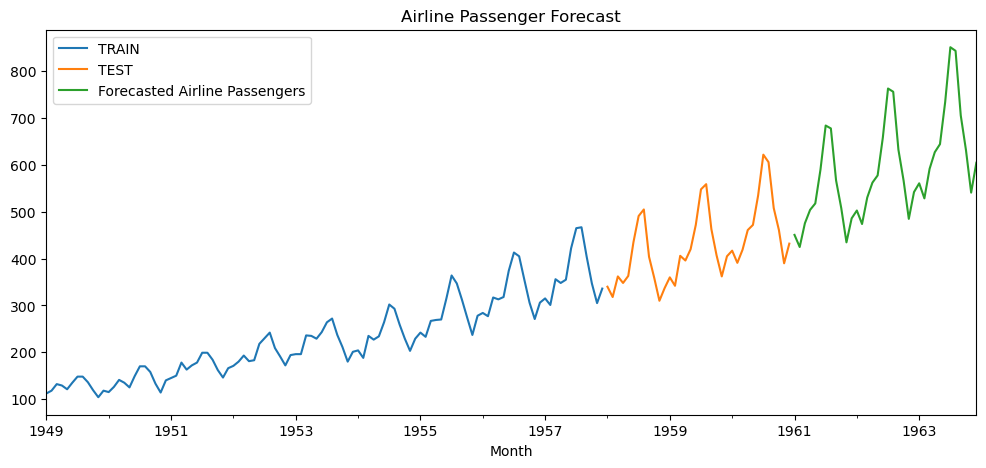

In [40]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,5))
forecast_predictions.plot(legend=True,label='Forecasted Airline Passengers')
plt.title('Airline Passenger Forecast')
plt.plot()

# Nota
Hay muchas más consideraciones que pueden ser tomadas en cuenta para modelar series de tiempo..... Refierase a: https://otexts.com/fpp2/stationarity.html